# DOPP 2020W Exercise 1
## Butterflies

The authors of scientific article on butterfly wing shapes [ 1 ] have made the data on which their analysis is based publicly available [ 2 ]. You are  asked to re-analyse that data. 

The data used by the article's authors is stored as an XLS file, with records spread over 10 sheets. In a first step, you have to load the data into Python and organize it before doing any analysis.

The aim of this exercise is to import some of the data from the XLSX file into Python and output a CSV file. The data to import and export into the CSV file must refer to the Experimental Brood only. The CSV file must contain a single grid with (one or more) columns:
* Name
* Sex
* Genotype
* Phenotype
* Wing perimeter
* Landmarks

The CSV file must contain one line for each "name" in the Experimental Brood sheet. The column headings for the landmarks should be "landmark 1 x", "landmark 1 y", "landmark 2 x", "landmark 2 y", …

<span style="color:red;font-weight:bold;">Important:</span> 
* You are <span style = "font-weight:bold">not allowed</span> to use NumPy, SciPy, or Pandas.
* The code must run on JupyterHub (here!). If the code does not run, you will not get the points for the non-running cells.
* Do not create global variables as they might be overriden!
* Task 5 will not be graded if you didn't attempt the previous tasks as well
* _Don't forget about the Quiz on TUWEL_, otherwise you won't be able to reach the full 100 points for this exercise.


[1] Jones, R.T., Poul, Y.L., Whibley, A.C., Mérot, C., ffrench‐Constant, R.H. and Joron, M. (2013), WING SHAPE VARIATION ASSOCIATED WITH MIMICRY IN BUTTERFLIES. Evolution, 67: 2323-2334. <a href = "doi:10.1111/evo.12114"> doi:10.1111/evo.12114 </a>

[2] <a href = "https://datadryad.org/stash/dataset/doi:10.5061/dryad.1s15q"> https://datadryad.org/stash/dataset/doi:10.5061/dryad.1s15q </a> and "WING paper Data for repository.xlsx" on JupyterHub.

In [1]:
import csv
import re
import matplotlib.pyplot as plt
import xlrd

## Task 1

Implement the function `load_data`.

This function takes an excel filepath as input and returns a dictionary which contains the data from the file. Every sheet and its content in the excel file corresponds to a key value pair in the dictionary. Rows will be encoded as lists of values and therefore a sheet becomes a list of lists.

Here is an example dictionary to showcase how the output should look like:

```python
{
    "sheet name": [
        ["column name 1", "column name 2"],
        ["first row string", 12.5],
        ["second row string", 5.5],
        ...
    ],
    ...
}
```

### Note

- Use the library `xlrd` to read the excel file
- Apply datatype conversions if possible e.g. `"12.5"` -> `12.5`
- Do not change sheet or column names e.g. lowercasing etc.
- Do not change row or column order of the tables
- Remove rows that do not represent data content e.g. descriptions, empty rows etc.
- Keep column names if they are present in the first row

In [2]:
def load_data(excel_path):
    """
    Load data from excel file
    
    Parameters
    ----------
    excel_path : str
        Path to wing paper excel file (.xlsx)
    
    Returns
    -------
    data : dictionary of list of lists
        Table data from wing paper excel file for all sheets
    """
    
    data = {}
    
    wb = xlrd.open_workbook(excel_path)
    sheets = wb.sheets()
    
    # iterate every relevant cell in the workbook
    for sheet in sheets:
        sheet_data = []
        for row in range(0,last_row(sheet)):
            row_data = []
            for col in range(0, sheet.ncols):
                cell = sheet.cell(row,col)
                cell_value = try_conversion(cell)
                row_data.append(cell_value)
            sheet_data.append(row_data)
        data[sheet.name] = sheet_data
    return data

# find last row by looking for the first empty row
# in the identifyer column (first column)
def last_row(sheet):
    # start at row 2 because 1 could be empty (Outline analysis)
    for row in range(2,sheet.nrows):
        if sheet.cell_type(row,0) == 0:
            return row

# try converting string values to int or float if possible
def try_conversion(cell):
    cell_value = cell.value
    # string values to float
    if cell.ctype == 1:
        try:
            cell_value = float(cell_value)
        except:
            pass
    # floats to int if possible
    if isinstance(cell_value, float) and cell_value.is_integer():
        cell_value = int(cell_value)
    return cell_value

In [3]:
DATA = load_data("WING paper Data for repository.xlsx")

In [4]:
# to make sure you have the right data structure
assert isinstance(DATA, dict)
assert all(isinstance(k, str) and isinstance(v, list) for k, vs in DATA.items() for v in vs)

## Task 2

Implement the function `landmark_coordinates_table`.

The sheet "Landmark coordinates" encodes wing color pattern landmark coordinates in a special format. Convert the contents of this sheet into a plain table format. The column headings of this table should be `name, landmark 1 x, landmark 1 y, landmark 2 x, landmark 2 y, ...`. The enumeration of the landmarks corresponds to the position in the list of the special format. The `name` column should contain the name of the organism which the landmarks belong to.

### Note

- Include the new column headings as the first row in the output

In [5]:
def landmark_coordinates_table(data):
    """
    Transform landmark coordinates sheet data from special format to table format described in Task 2
    
    Parameters
    ----------
    data : dictionary of list of lists
        Data loaded from your `load_data` function in Task 1
    
    Returns
    -------
    output : list of lists
        Transformed landmark coordinates from landmark coordinates sheet
    """
    
    output = []
    sheet = data['Landmark coordinates']
    
    # create headers
    headers = ['name']
    for xy in range(1,21):
        headers.append(f'landmark x {xy}')
        headers.append(f'landmark y {xy}')
    output.append(headers)
    
    # transform rows
    transformed_row = []
    for row in sheet:
        # only numeric values are landmarks
        if isinstance(row[0], float) or isinstance(row[0], int):
            transformed_row.append(row[0])
            transformed_row.append(row[1])
        # IMAGE=* is in every row after the landmakrs
        elif isinstance(row[0], str) and row[0].startswith('IMAGE'):
            # extract name from image name (always same position)
            name = int(row[0][11:15])
            # insert name as identifyer to first position in row
            transformed_row.insert(0, name)
            output.append(transformed_row)
            transformed_row = []
    
    return output

In [6]:
DATA["Landmark coordinates"] = landmark_coordinates_table(DATA)

## Task 3

Implement the function `build_csv`.

Write a CSV file which contains the following data for each "name" in the "Experimental brood" sheet:

- name
- sex
- genotype
- phenotype
- wing perimeter
- landmark 1 x, landmark 1 y, landmark 2 x, ...

The CSV file should be written to the path provided by the argument `output_path`.

### Note

- The column headings must be named as in the bullet list above i.e. lowercase, singular etc.
- If some cells in the table don't have values then they should be empty
- The order of the rows or columns doesn't matter

In [7]:
def build_csv(data, output_path):
    """
    Build and write a CSV file
    
    Parameters
    ----------
    data : dictionary of list of lists
        Data loaded from your `load_data` function from Task 1 and modified in Task 2
    output_path : str
        Path to store CSV file to
    """
    
    output = data['Experimental brood']
    
    wing_perimeter = data['Wing perimeter']
    landmarks = data['Landmark coordinates']
    
    # add headers to first row
    output[0].append('wing perimeter')
    output[0].extend(landmarks[0][1:])

    # add wing perimeter by row
    for i in range(1,len(output)):
        output[i].append(wing_perimeter[i][2])
    
    # add landmarks by row
    for o in output[1:]:
        for l in landmarks:
            if o[0] == l[0]:
                o += l[1:]
    
    # add empty values
    for o in output:
        if len(o) < len(output[0]):
            o += ['' for i in range(0, len(output[0]) - len(o))]

    # write list of lists to csv file
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(output)

In [8]:
build_csv(DATA, "wings.csv")

## Task 4

Implement the function `plot_histogram`.

Use matplotlib to inspect the distribution of wing perimeters by plotting a histogram of the wing perimeters. 

Choose appropriate parameters/labels for:
- bins
- axis labels
- title

In [9]:
def plot_histogram(csv_path):
    """
    Plot histogram of wing perimeter values from the CSV file created by `build_csv` in Task 3
    
    Parameters
    ----------
    csv_path : str
        Path where the CSV file is stored
    """
    
    # get relevant data
    wing_perimeters = []
    with open(csv_path, 'r') as csv_file:
        csv_data = csv.reader(csv_file)
        for row in csv_data:
            wing_perimeters.append(row[4])
    wing_perimeters = [float(x) for x in wing_perimeters[1:]]
    
    # plot histogram
    fig, ax = plt.subplots()
    ax.hist(wing_perimeters, bins=12)
    ax.set_title('Wing Perimeters of Experimental Brood')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Wing perimeter')
    fig.show()

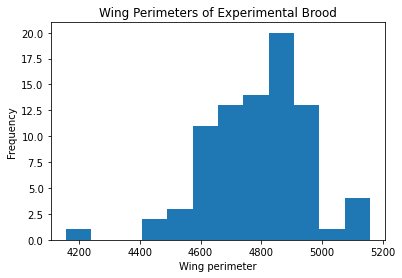

In [10]:
plot_histogram("wings.csv")

## Task 5

<span style = "font-weight:bold;">Reflection</span> 

Write in the field below your observations about the Dryad data set. For example: Were there any discrepancies in the data set? If yes, how did you handle them? Size of the broods, etc.

The dataset is published in a way which maks reproducing the experiments challenging.

One of the main problems is that the data for the experimental brood is spread over multiple worksheets. We solve this by transforming and combining the data in multiple steps into one csv.

Another big challenge is that the authors did not use the same identifyers for all sheets. They use a name which identifyes each butterfly but do not use the same for all worksheets. Another indentifer where the orginal name was used in the identifyer string is used most of the time. We were able to extract the orginal name from this by string slycing string using string slicing. We could have also used regular expressions for this but it was easyer with string slycing when each "name" had the orginal name identifyer in the same position. 

The description of the data is in the same sheet as the data which makes it more difficult to extract the data correctly. Because in each sheet the data in the first row is continousli not empty (identifyer in first column) we can find where the first empty row is and the description of the data starts. A much better approch of the authors would be to seperate description of data and the data in seperate files or at least sheets.

Landmarks are listed in a very different form than all other data and it is not very clear which landmark belongs to which butterfly. Because there exist no landmarks for the first butterfly in the experimental brood this is even more unclea. We were able to extract the identifyer for the butterfly form the IMAGE name which is listed after the list of landmarks for each butterfly. By transforming the 20 landmarks into "landmark 1 x, landmark 1y, landmark 2 x, ..." we are able to bring the data into a tidy format.

Other discrepancys we discovered douring the exercises but are not relevant for the data we needed are the following. In some worksheets there are multiple columns "name" and some columns have no header which makes it very unclear what this column refers to. In the outliner analysis worksheet there is a half empty second row which makes utilizing this data problematic. Also some numbers were saved with ',' to seperate the comman and others used '.' 